# rl5E.ipynb

This notebook contains the fifth step in the 5-step process outlined in November 13th, 2020, in order to produce an actor-critic architecture for pendulum control. 

In step 1 we create a network with N units that takes the activity of 1 unit and transforms it into a bell-shaped representation.  
In step 2 we put 2 of those as the inputs to a (N/2)x(N/2) grid, and visualized.  
In step 3 we took the network from step 2 and connected it to the current SP and SD units in `test3p2` to see if the angle is being tracked.  
In step 4 we will connect a $V$ neuron to the L (RBF) layer, and tweak TD learning so its output starts to reflect the angular error.  
In step 5 the output of $V$ is used to configure a controller. There are three basic options outlined in the November 20th, 2020 entry of the log, and a fourth option in Nov. 30th. This fifth option was introduced in December 1st, 2020.

This started as a clone of `rl5C-Copy1`, which means it is setup for `rga_sig` units in C.

Currently configured for learning of the value function (e.g. using an `x_switch_sig` unit in X, and a SP-->X connection.


In [1]:
%cd ../..
from draculab import *
import numpy as np
import matplotlib.pyplot as plt
import time
from tools.visualization import plotter

/home/z/projects/draculab/notebook


In [2]:
#===================================================================
#================ CREATE THE NETWORK ===============================
#===================================================================

#np.random.seed(123456) # always the same random values
np.random.seed()   # different random values ever run

# some parameters 
C_type = "rga_sig" # unit type for the C population
des_angs = np.pi*(-1. + 2.*np.random.random(10000))
#des_sf = 0.05 + 0.8*np.random.random(10000) # list of "predicted" SF values| set below now
pres_interv = 5. # interval that desired values last
par_heter = 0.1 # range of heterogeneity as a fraction of the original value
randz = lambda : (1. + par_heter*(np.random.rand()-0.5))
randz2 = lambda : (1. + par_heter*(np.random.rand(2)-0.5))
randz4 = lambda : (1. + par_heter*(np.random.rand(4)-0.5))
SN = 20 # number of units to represent one angle
No2 = int(np.ceil(SN/2)) # L wiill have (No2)**2 units

# PARAMETER DICTIONARIES
net_params = {'min_delay' : 0.005,
              'min_buff_size' : 8 }
#--------------------------------------------------------------------
# Unit parameters
#--------------------------------------------------------------------
A_params = {'type' : unit_types.logarithmic,
            'init_val' : 0.,
            'tau' : 0.01, # 0.02
            'tau_fast': 0.005,
            'thresh' : 0. } #[0.1, 0.1, 0.1, 0.1] } 
if C_type == "am_pm":
    init_base = np.array([0.5, 0.5, 2.*np.pi, 0.5])
    C_unit_type = unit_types.am_pm_oscillator
elif C_type == "am2D":
    init_base = np.array([0.5, 0.5])
    C_unit_type = unit_types.am_oscillator2D
elif C_type == "am_pulse":
    init_base = np.array([0.5, 0.5])
    C_unit_type = unit_types.am_pulse
elif C_type == "am":
    init_base = np.array([0.5, 0.5, 0.5])
    C_unit_type = unit_types.am_oscillator
elif C_type == "rga_sig":
    init_base = np.array([0.5])
    C_unit_type = unit_types.rga_sig
C_params = {'type' : C_unit_type, #unit_types.am_pm_oscillator,
            'integ_meth' : 'euler_maru', #'euler_maru', #'odeint',
            'tau_u' : 0.5 * randz2(), # 0.4*randz2()
            'tau_c' : 0.1 * randz2(), # 0.2
            'tau_t' : 1.,
            'tau_s' : 0.02,
            #'delay' : 0.35,
            'init_val' : [r*init_base for r in np.random.random(2)],
            'multidim' : False if C_type=="rga_sig" else True,
            'omega' : 2.*np.pi,
            'F' : 'zero', #'input_sum',
            'A' : 0.5,
            'slope' : 2., # for rga_sig
            'thresh' : 0.2, # for rga_sig
            'integ_amp' : 0., # for rga_sig
            'tau' : 0.02, # for rga_sig
            'tau_fast': 0.01, #0.02,
            'tau_mid' : 0.05, #0.1,
            'tau_slow' : 3.,
            'custom_inp_del' : 150,
            'delay' : 0.31,
            'mu' : 0.,
            'sigma' : 0.4 }
# L is the "RBF" layer to represent S_P, S_F
L_params = {'type' : unit_types.sigmoidal,
            'delay' : .3,
            'thresh' : 2.,
            'slope' : 5.,
            'tau' : 0.02,
            'init_val' : 0.5 }
L_geom = {'shape' : 'sheet',
          'arrangement' : 'grid',
          'rows' : No2,
          'columns' : No2,
          'center' : [0., 0.],
          'extent' : [1., 1.] }

M_params = {'type' : unit_types.m_sig,
            'thresh' : 0.5 * randz2(),
            'slope' : 2.5 * randz2(),
            'init_val' : 0.2 * randz2(),
            'delay' : 0.35,
            'n_ports' : 4,
            'tau_fast': 0.01, #0.2, #0.01,
            'tau_mid': 0.05, #1., #0.05,
            'tau_slow' : 8.,
            'tau' : 0.01 * randz2(),
            'coordinates' : [np.array([0.1, 0.8]), np.array([0.4, 0.8])],
            'integ_amp' : 0.,
            'custom_inp_del' : int(np.round(0.3/net_params['min_delay'])) ,
            'des_out_w_abs_sum' : 1.6 }
MPLEX_params = {'type' : unit_types.linear_mplex,
                'init_val' : 0.,
                'tau' : 0.01 }
# plant parameters
P_params = {'type' : plant_models.pendulum, #bouncy_pendulum,
            'length' : 0.5,
            'mass' : 1.,
            'init_angle' : 0.,
            'init_ang_vel' : 0.,
            'g' : 0.,
            'inp_gain' : 2.,
            'mu' : 1.5,
            'bound_angle' : True,
            'pi_visco' : 0.05,
            'tau' : 0.05 } # a made-up time constant for the plant 
                          # see create_freqs_steps below
# Reward unit parameters
R_params = {'type' : unit_types.layer_dist,
            'thresh' : 4., # for large args you want -slope(arg - thresh) to get large
            'slope' : -1.,
            'tau' : 0.01,
            'coordinates' : np.array([.3, .8]),
            'init_val' : 0.3 }
# S1 and S2 provide the distributed angle representations
S_params = {'type' : unit_types.bell_shaped_1D,
            'init_val' : 0.1,
            'tau' : 0.01,
            'center' : list(np.linspace(0., 1., SN)),
            'b' : 50. }
S1_params = S_params.copy() # the input column on the left
S2_params = S_params.copy() # the input row below
S1_params['coordinates'] = [np.array([-.6, -.5 + i/SN]) for i in range(SN)]
S2_params['coordinates'] = [np.array([-.5 + i/SN, -.6]) for i in range(SN)]
# SF, SP
SF_params = {'type' : unit_types.sigmoidal,
             'thresh' : 0.,
             'slope' : 1.,
             'init_val' : 0.2,
             'tau' : 0.02 }  # 0.05
## The desired values for SF
des_sf = 1./(1. + np.exp(-SF_params['slope']*(des_angs - SF_params['thresh'])))

SP_params = {'type' : unit_types.source,
             'init_val' : des_sf[0],
             'tau_fast' : 0.01,
             'tau_mid' : 0.2,
             'function' : lambda t: des_sf[int(round(t/pres_interv))] }
# 1-D error units
SPF_params = {'type' : unit_types.sigmoidal,
              'thresh' : 0.5 * randz2(),
              'slope' : 5. * randz2(),
              'init_val' : 0.3 * randz2(),
              'tau_fast': 0.005,
              'tau_mid': 0.05,
              'tau_slow' : 5.,
              'tau' : 0.02 * randz2() }
# Angle transformation unit
T_params = {'type' : unit_types.source,
            'init_val' : des_sf[0],
            'function' : lambda t: None } # to be set after unit creation
# value unit
V_params = {'type' : unit_types.td_sigmo,
            'delay' : .5,
            'init_val' : 0.1,
            'thresh' : 0.3,
            'slope' : 1.,
            'tau' : 0.02,
            'tau_slow' : 300,
            'delta' : 1.,
            'coordinates' : np.array([.8, .8])}
# The configurator unit
X_params = {'type' : unit_types.x_switch_sig, #x_sig,
            'init_val' : 0.1,
            'slope' : 5.,
            'thresh' : 0.,
            'tau' : 0.02,
            'delay' : 0.35,
            'tau_fast' : 0.01,
            'tau_mid' : 0.1,
            'tau_slow' : 50.,
            'integ_amp' : 0.,
            'sw_thresh' : 0.05,
            'sw_len' : 0.2,
            'switch' : True,
            'coordinates' : np.array([0.7, 0.3]),
            'custom_inp_del' :  int(np.round(0.3/net_params['min_delay'])),
            'des_out_w_abs_sum' : 1.} # usually not used

# units to track synaptic weights or other values
track_params = {'type' : unit_types.source,
                'init_val' : 0.02,
                'function' : lambda t: None }

#--------------------------------------------------------------------
# Connection dictionaries
#--------------------------------------------------------------------
# Afferent to motor error selection
A__M_conn = {'rule' : 'all_to_all',
             'delay' : 0.02 }
A__M_syn = {'type' : synapse_types.inp_sel, 
            'inp_ports' : 2, # the deault for m_sig targets
            'error_port' : 1, # the default for m_sig targets
            'aff_port' : 2,
            'lrate' : 5., # negative rate for m_sig targets with value inputs
            'w_sum' : .8,
            'w_max' : 0.5,
            'init_w' : .1 }
# lateral connections in C
C__C_conn = {'rule': 'one_to_one',
             'allow_autapses' : False,
             'delay' : 0.015 }
C__C_syn = {'type' : synapse_types.static,
            'lrate' : 0.1,
            'inp_ports': 1,
            'init_w' : -1.5 }  # Changed from usual -1
# spinal units to plant
C0__P_conn = {'inp_ports' : 0,
             'delays': 0.01 }
C0__P_syn = {'type': synapse_types.static,
            'init_w' : 2. }
C1__P_conn = C0__P_conn
C1__P_syn = {'type': synapse_types.static,
             'init_w' : -2. }
# expanded state to value unit
L__V_conn = {'rule': 'all_to_all',
            'delay': 0.02 }
L__V_syn = {'type' : synapse_types.td_synapse,
            'lrate': .05,
            'gamma' : 0.6,
            'inp_ports': 0,
            'init_w' : 0.2 * np.random.random(No2*No2), # 0.05
            'max_w' : 1.,
            'w_sum' : 30. }
# state to configurator
L__X_conn = {'rule': 'all_to_all',
            'delay': 0.02 }
L__X_syn = {'type' : synapse_types.diff_rm_hebbian,
            'lrate': 1.,
            'inp_ports': 0, # default for x_sig, m_sig targets
            #'l_port' : 3,
            #'s_port' : 0,
            #'v_port' : 1,
            'init_w' : 0.2 * np.random.random(No2*No2),
            'w_sum' : 20. }
# motor error to spinal
M__C_conn = {'rule': 'all_to_all',
             'delay': 0.02 }
M__C_syn = {'type' : synapse_types.rga_21,
            'lrate': 400., #50
            'inp_ports': 0,
            'w_sum' : 2.,
            'init_w' : {'distribution':'uniform', 'low':0.05, 'high':.1}}
# motor error lateral connections
M__M_conn = {'rule': 'one_to_one',
             'allow_autapses' : False,
             'delay' : 0.01 }
M__M_syn = {'type' : synapse_types.static,
            'lrate' : 0.1,
            'inp_ports': 3, # default for m_sig targets
            'init_w' : -1. }
# motor error to plant
# M0__P_conn = {'inp_ports' : 0,
#              'delays': 0.01 }
# M0__P_syn = {'type': synapse_types.static,
#             'init_w' : 2. }
# M1__P_conn = M0__P_conn
# M1__P_syn = {'type': synapse_types.static,
#              'init_w' : -2. }
# multiplexer SP selection to X
MPLEX1__X_conn = {'rule' : 'one_to_one',
                  'delay' : 0.01}
MPLEX1__X_syn = {'type' : synapse_types.static,
                 'init_w' : 1.,
                 'inp_ports' : 2 }
# plant to sensory/motor
P__A_conn = {'port_map' : [[(0,0)], [(1,0)], [(0,0)], [(1,0)]],
             'delays' : 0.02 }
P__A_syn = {'type' : synapse_types.static,
            'init_w' : [1., 1., -1., -1.] }
P__SF_conn = {'port_map' : [(0,0)],
              'delays' : 0.01 }
P__SF_syn = {'type' : synapse_types.static,
             'init_w' : 1. }
# reward to value unit
R__V_conn = {'rule' : 'one_to_one',
             'delay' : 0.01 }
R__V_syn = {'type' : synapse_types.static,
            'inp_ports' : 1,
            'init_w' : 1.}
# distributed angle to RBF layer
S1__L_conn_spec = {'connection_type' : 'divergent',
                  'mask' : {'circular' : {'radius' : 2. }},
                  'kernel' : 1.,
                  'delays' : {'linear' : {'c' : 0.01, 'a': 0.01}},
                  'weights' : {'gaussian' : {'w_center' : 1.5, 'sigma' : 0.01}},
                  'dist_dim' : 'y',
                  'edge_wrap' : True,
                  'boundary' : {'center' : [-0.05, 0.], 'extent':[1.1, 1.]} }
S2__L_conn_spec = S1__L_conn_spec.copy()
S2__L_conn_spec['dist_dim'] = 'x'
S2__L_conn_spec['boundary'] = {'center' : [0., -0.05], 'extent':[1., 1.1]}
S1__L_syn_spec = {'type' : synapse_types.static }
S2__L_syn_spec = {'type' : synapse_types.static }
# distributed angle to layer distance (reward)
S1__R_conn = {'rule': 'all_to_all',
              'delay': 0.01 }
S1__R_syn = {'type': synapse_types.static,
             'inp_ports' : 0,
             'init_w' : 1. }
S2__R_conn = {'rule': 'all_to_all',
              'delay': 0.01 }
S2__R_syn = {'type': synapse_types.static,
             'inp_ports' : 1,
             'init_w' : 1. }
# SF rate representation to distributed representation
SF__S_conn = {'rule' : 'all_to_all',
             'delay' : 0.01 }
SF__S_syn = {'type' : synapse_types.static,
            'init_w' : 1. }
# SF/SP to multiplexer
SF__MPLEX_conn = {'rule' : 'all_to_all',
                  'delay' : 0.01 }
SF__MPLEX_syn = {'type' : synapse_types.static,
                 'inp_ports' : [0, 1],
                 'init_w' : 1. }
SP__MPLEX_conn = {'rule' : 'all_to_all',
                  'delay' : 0.01 }
SP__MPLEX_syn = {'type' : synapse_types.static,
                 'inp_ports' : [0, 1],
                 'init_w' : 1. }
# SF/SP to SPF
SFe__SPF_conn = {'rule' : "all_to_all",
                 'delay' : 0.01 }
SFi__SPF_conn = {'rule' : "all_to_all",
                 'delay' : 0.015 }
SFe__SPF_syn = {'type' : synapse_types.static,
                'init_w' : 1. }
SFi__SPF_syn = {'type' : synapse_types.static,
                'init_w' : -1. }
SPe__SPF_conn = {'rule' : "all_to_all",
                 'delay' : 0.01 }
SPi__SPF_conn = {'rule' : "all_to_all",
                 'delay' : 0.015 }
SPe__SPF_syn = {'type' : synapse_types.static,
                'init_w' : 1. }
SPi__SPF_syn = {'type' : synapse_types.static,
               'init_w' : -1. }
# SP rate representation to distributed representation
SP__S_conn = SF__S_conn
SP__S_syn = SF__S_syn
# SPF to M
SPF__M_conn = {'rule': 'one_to_one',
               'delay': 0.01 }
SPF__M_syn = {'type' : synapse_types.static,
              'inp_ports' : 1,
              'lrate' : 20.,
              'input_type' : 'error',
              'init_w' : 1. }
# rotated angle to SF[1]
T__SF_conn = {'rule': 'one_to_one',
             'delay': 0.01 }
T__SF_syn = {'type' : synapse_types.static,
            'inp_ports' : 0,
            'init_w' : P__SF_syn['init_w'] }
# Value to configurator
V__X_conn = {'rule': 'all_to_all',
             'delay': 0.01 }
V__X_syn = {'type' : synapse_types.static,
            'inp_ports' : 1,
            'init_w' : 1. }
# configurator to multiplexer
X__MPLEX_conn = {'rule': 'all_to_all',
                 'delay': 0.01 }
X__MPLEX_syn = {'type' : synapse_types.static,
                'inp_ports' : 2,
                'init_w' : 1. }

def create_freqs_steps(n, w, r):
    """ Returns a 2-tuple with the lists required for heterogeneous frequencies.
    
        We assume that the important loop for the learning rule in the C units
        is the one going through C-P-M-C
        Args:
            n : number of units
            w : base omega value (rad)
            r : amplitude of noise as fraction of original value
        Returns
            2-tuple : (freqs, steps)
            freqs : a list with n angular frequencies.
            steps : a list with the corresponding delays. 
    """
    ws = w * (1. + r*((np.random.random(n) - 0.5)))
    ws = ws / C_params['tau_t'] # angular frequencies
    cp_del = np.arctan(np.mean(P_params['tau'])*ws)/ws
    pm_del = np.arctan(np.mean(M_params['tau'])*ws)/ws
    am_del = np.arctan(np.mean(A_params['tau'])*ws)/ws
    D = [C0__P_conn['delays'], np.mean(P__A_conn['delays']), 
         A__M_conn['delay'], M__C_conn['delay'] ]
    d1 = cp_del + pm_del + am_del + sum(D)
    del_steps = [int(d) for d in np.ceil(d1/net_params['min_delay'])]
    return (list(ws), del_steps)

#--------------------------------------------------------------------
# CREATING UNITS
#--------------------------------------------------------------------
net = network(net_params)
topo = topology()

A = net.create(4, A_params)
# creating C with heterogeneous frequencies
omegas, del_steps = create_freqs_steps(2, C_params['omega'], par_heter)
C_params['omega'] = omegas
C_params['custom_inp_del'] = del_steps
C = net.create(2, C_params)
L = topo.create_group(net, L_geom, L_params)
M = net.create(2, M_params)
MPLEX = net.create(2, MPLEX_params)
P = net.create(1, P_params)
R = net.create(1, R_params)
S1 = net.create(SN, S1_params)
S2 = net.create(SN, S2_params)
SF = net.create(2, SF_params)
SP = net.create(2, SP_params)
SPF = net.create(2, SPF_params)
T = net.create(1, T_params)
V = net.create(1, V_params)
X = net.create(1, X_params)

# tracking units
M_C0_track = net.create(2, track_params) # to track weights from M to C0
A_M0_track = net.create(4, track_params) # to track weights from A to M0
xp_track = net.create(1, track_params) # del_avg_inp_deriv of C0 at port 1
up_track = net.create(1, track_params) # to track the derivative of C0
sp_track = net.create(1, track_params) # avg_inp_deriv_mp for C0 at port 0
spj_track = net.create(1, track_params) # input derivative for SPF0--C0
if C_type != "rga_sig":
    dc_track = net.create(2, track_params) # DC component of C units
    
# Configuring transformation unit
def t_fun(time):
    """ Pendulum angle after a \pi rads rotation of the coordinate system.
    
        Normally the bound angle for the pendulum is between -pi and pi. This
        function retrieves the pendulum angle in the 0, 2pi interval.
    
        Args:
            time : time at which the angle is retrieved
        Returns:
            1-D scalar with rotated angle.
    """
    x = net.plants[P].get_state_bound(time)[0]
    return x - np.pi if x < np.pi and x > 0 else np.pi + x
net.units[T[0]].set_function(t_fun)

# Configuring alternate desired angle unit
def alt_des_fun(time):
    """ The alternate desired SF value. """
    sd = des_sf[int(round(time/pres_interv))]
    sd_inv = np.log(sd / (1.-sd))/SF_params['slope'] + SF_params['thresh']
    t = sd_inv - np.pi if sd_inv < np.pi and sd_inv > 0 else np.pi + sd_inv
    return 1. / ( 1. + np.exp(-SF_params['slope']*(t - SF_params['thresh'])) )
net.units[SP[1]].set_function(alt_des_fun)
    
#--------------------------------------------------------------------
# CONNECTING
#--------------------------------------------------------------------
net.connect(A, M, A__M_conn, A__M_syn) # this connection should be made before
net.connect([C[0]], [C[1]], C__C_conn, C__C_syn)
net.connect([C[1]], [C[0]], C__C_conn, C__C_syn)
net.set_plant_inputs([C[0]], P, C0__P_conn, C0__P_syn)
net.set_plant_inputs([C[1]], P, C1__P_conn, C1__P_syn)
net.connect(L, V, L__V_conn, L__V_syn)
net.connect(L, X, L__X_conn, L__X_syn)
net.connect(M, C, M__C_conn, M__C_syn)
net.connect([M[0]], [M[1]], M__M_conn, M__M_syn)
net.connect([M[1]], [M[0]], M__M_conn, M__M_syn)

net.connect([MPLEX[0]], [SPF[0]], SFe__SPF_conn, SFe__SPF_syn)
net.connect([MPLEX[1]], [SPF[0]], SPi__SPF_conn, SPi__SPF_syn)
net.connect([MPLEX[0]], [SPF[1]], SFi__SPF_conn, SFi__SPF_syn)
net.connect([MPLEX[1]], [SPF[1]], SPe__SPF_conn, SPe__SPF_syn)

net.connect([MPLEX[1]], X, MPLEX1__X_conn, MPLEX1__X_syn)

net.set_plant_outputs(P, [SF[0]], P__SF_conn, P__SF_syn)
net.set_plant_outputs(P, A, P__A_conn, P__A_syn) 
topo.topo_connect(net, S1, L, S1__L_conn_spec, S1__L_syn_spec)
topo.topo_connect(net, S2, L, S2__L_conn_spec, S2__L_syn_spec)
net.connect(S1, R, S1__R_conn, S1__R_syn)
net.connect(S2, R, S2__R_conn, S2__R_syn)
net.connect([SF[0]], S1, SF__S_conn, SF__S_syn)

net.connect(SF, [MPLEX[0]], SF__MPLEX_conn, SF__MPLEX_syn)
net.connect(SP, [MPLEX[1]], SP__MPLEX_conn, SP__MPLEX_syn)

net.connect([SP[0]], S2, SP__S_conn, SP__S_syn)
net.connect(SPF, M, SPF__M_conn, SPF__M_syn)
net.connect(R, V, R__V_conn, R__V_syn)
net.connect(T, [SF[1]], T__SF_conn, T__SF_syn)
net.connect(V, X, V__X_conn, V__X_syn)
net.connect(X, MPLEX, X__MPLEX_conn, X__MPLEX_syn)

# SETTING UP WEIGHT TRACKING -- depends on the order of statements above!!!!!!
# This is dependent on the order in which net.connect is called above;
net.units[M_C0_track[0]].set_function(lambda t: net.syns[C[0]][1].w) # M0--C0
net.units[M_C0_track[1]].set_function(lambda t: net.syns[C[0]][2].w) # M1--C0
# Nothing should connect to M0 before A
net.units[A_M0_track[0]].set_function(lambda t: net.syns[M[0]][0].w) # P0--M0
net.units[A_M0_track[1]].set_function(lambda t: net.syns[M[0]][1].w) # P1--M0
net.units[A_M0_track[2]].set_function(lambda t: net.syns[M[0]][2].w) # -P0--M0
net.units[A_M0_track[3]].set_function(lambda t: net.syns[M[0]][3].w) # -P1--M0

# SETTING TRACKING OF PLASTICITY FACTORS FOR M0-->C0
net.units[xp_track[0]].set_function(lambda t: net.units[C[0]].del_avg_inp_deriv_mp[1])
po_de = net.units[C[0]].custom_inp_del
net.units[up_track[0]].set_function(lambda t: net.units[C[0]].get_lpf_fast(po_de) - 
                                    net.units[C[0]].get_lpf_mid(po_de))
net.units[sp_track[0]].set_function(lambda t: net.units[C[0]].avg_inp_deriv_mp[0])
ds = net.syns[C[0]][0].delay_steps
net.units[spj_track[0]].set_function(lambda t: net.units[M[0]].get_lpf_fast(ds) - 
                                     net.units[M[0]].get_lpf_mid(ds))

# SETTING UP TRACKING OF C STATE VARIABLES
if C_type != "rga_sig":
    net.units[dc_track[0]].set_function(lambda t: net.units[C[0]].buffer[1, -1])
    net.units[dc_track[1]].set_function(lambda t: net.units[C[1]].buffer[1, -1])

In [60]:
sim_time = 200.
#ratio = 15.1 # cns-amd
ratio = 10. # breaker
#ratio = 1.6 # breaker, no L,V
secs2finish = sim_time * ratio
lt1 = time.localtime()
hrs, hrs_rem = divmod(secs2finish, 3600)
mins, mns_rem = divmod(hrs_rem, 60)
xtra_hrs, new_mins = divmod(lt1.tm_min+mins, 60)
print("Expecting to finish at: %d:%d (%d seconds)" % 
      (lt1.tm_hour+hrs+xtra_hrs, new_mins, secs2finish))
start_time = time.time()

times, data, plant_data  = net.run(sim_time)

print('Execution time is %s seconds' % (time.time() - start_time))
lt2 = time.localtime
print("Finished at " + time.strftime('%H:%M'))
data = np.array(data)

# import cProfile
# import pstats
# cProfile.run('times, data, plant_data = net.run(2.)', 'restats')
# prof = pstats.Stats('restats')
# prof.sort_stats('cumulative').print_stats(30)
# data = np.array(data

Expecting to finish at: 17:28 (2000 seconds)
Execution time is 1797.5632801055908 seconds
Finished at 17:25


In [12]:
# Configure X switching
net.units[X[0]].switch = False

In [3]:
# Setting, fixing controller weights
# standard values:
# A__M_mat = np.rray([[0.27141863, 0.29511766, 0.23279135, 0.20067437],
#                     [0.23307357, 0.1957229 , 0.28739239, 0.28380952]])

# M__C_mat = np.array([[0.0295056,  2.05108517],
#                      [2.05111951, 0.02950648]])
# limit values:
A__M_mat = np.array([[0.4, .5, 0.08, 0.018],
                    [0.05, 0. , 0.4, 0.5]])

M__C_mat = np.array([[0.,  2.15],
                     [2.15, 0.]])


for m_idx, m_id in enumerate(M):
    for c_idx, c_id in enumerate(C):
        syn_list = net.syns[c_id]
        for syn in syn_list:
            if syn.preID == m_id:
                syn.w = M__C_mat[c_idx, m_idx]
                syn.alpha = 1e-5 # slowing down learning
                break

for a_idx, a_id in enumerate(A):
    for m_idx, m_id in enumerate(M):
        syn_list = net.syns[m_id]
        for syn in syn_list:
            if syn.preID == a_id:
                syn.w = A__M_mat[m_idx, a_idx]
                syn.alpha = 1e-5 # slowing down learning
                break

In [3]:
# Setting state to value and configuration connections
# L__V connections
L__V_w_mat = np.array([[0.06707852, 0.08050805, 0.08251277, 0.0848967 , 0.11308397,
        0.22620515, 0.55417782, 0.79372144, 0.6876465 , 0.34133315],
       [0.05831077, 0.06782342, 0.0683293 , 0.07022091, 0.11494818,
        0.39138445, 0.76794173, 0.8261277 , 0.67280354, 0.21302279],
       [0.06927103, 0.07770868, 0.07423635, 0.0958128 , 0.22412081,
        0.88519015, 0.83731818, 0.74667032, 0.37029254, 0.12680992],
       [0.06355582, 0.07839918, 0.07985409, 0.13819303, 0.59258314,
        0.94288044, 0.94205254, 0.62638352, 0.22158974, 0.09622283],
       [0.09752386, 0.11201396, 0.15942037, 0.33589917, 0.94694619,
        0.94364951, 0.94158053, 0.49580644, 0.16875629, 0.10859242],
       [0.05849918, 0.10646575, 0.21879212, 0.50010959, 0.93675195,
        0.95474715, 0.81635391, 0.1684281 , 0.09194431, 0.0678801 ],
       [0.06538704, 0.14245426, 0.25909012, 0.62818014, 0.84615674,
        0.85285463, 0.2504853 , 0.09830766, 0.0774161 , 0.06545088],
       [0.07089092, 0.19095169, 0.36402194, 0.56810343, 0.64869201,
        0.3858086 , 0.11388829, 0.07304715, 0.06914705, 0.05785098],
       [0.10377571, 0.29057907, 0.4846453 , 0.54810147, 0.42698425,
        0.20791294, 0.10538757, 0.08588755, 0.08342509, 0.06574458],
       [0.0442126 , 0.19017776, 0.28810858, 0.31472478, 0.17831433,
        0.13603035, 0.08702217, 0.06114519, 0.05471354, 0.03789069]])
for i in range(No2):
    for j in range(No2):
        net.syns[V[0]][i*No2 + j].w = L__V_w_mat[i,No2-j-1]
        
# L__X connections
L__X_w_mat = np.array([[0.40752688, 0.37469521, 0.27107189, 0.07440391, 0.07721186,
        0.02501925, 0.1069174 , 0.36086656, 0.25451684, 0.1970959 ],
       [0.03248544, 0.12786399, 0.25038678, 0.07363218, 0.15592582,
        0.3209681 , 0.21450277, 0.14253252, 0.13839743, 0.02859877],
       [0.16063949, 0.11147799, 0.27231511, 0.02594056, 0.23425097,
        0.05338877, 0.22996257, 0.15253259, 0.10512869, 0.01853192],
       [0.09938977, 0.30471093, 0.22959084, 0.10066124, 0.30352081,
        0.16611423, 0.34821997, 0.41204232, 0.19561455, 0.16056902],
       [0.25567157, 0.32287206, 0.20603859, 0.41744145, 0.35149283,
        0.09395332, 0.09029175, 0.13055691, 0.32364473, 0.04394644],
       [0.33564868, 0.10760629, 0.21296657, 0.38755765, 0.34745628,
        0.19784955, 0.05891823, 0.05001186, 0.23129886, 0.05401135],
       [0.2958786 , 0.11304302, 0.22865108, 0.27331804, 0.35495965,
        0.37116654, 0.28410601, 0.16606815, 0.17502019, 0.40636905],
       [0.11275785, 0.38208906, 0.29141882, 0.27556185, 0.06705766,
        0.01623226, 0.272555  , 0.31099133, 0.36412567, 0.32744701],
       [0.09233795, 0.10323469, 0.05420472, 0.22254801, 0.24501301,
        0.03673654, 0.18112763, 0.08422684, 0.09986006, 0.20714832],
       [0.20444364, 0.32074134, 0.34750473, 0.08088457, 0.19255964,
        0.00560003, 0.08101304, 0.23646438, 0.22140521, 0.35592552]])
for i in range(No2):
    for j in range(No2):
        net.syns[X[0]][i*No2 + j].w = L__X_w_mat[i,No2-j-1]
        

In [3]:
# running in two stages. Initial high learning rate and viscosity.
sim_time = 150.
#ratio = 15.1 # cns-amd
#ratio = 20. # breaker
ratio = 1.6 # breaker, no L,V
secs2finish = sim_time * ratio
lt1 = time.localtime()
hrs, hrs_rem = divmod(secs2finish, 3600)
mins, mns_rem = divmod(hrs_rem, 60)
xtra_hrs, new_mins = divmod(lt1.tm_min+mins, 60)
print("Expecting to finish firstst simulation at %d:%d (%d seconds)" % 
      (lt1.tm_hour+hrs+xtra_hrs, new_mins, secs2finish))
start_time = time.time()

times, data, plant_data  = net.run(sim_time)

print('Initial execution time is %s seconds' % (time.time() - start_time))
lt2 = time.localtime
print("Finished at " + time.strftime('%H:%M'))
data = np.array(data)

sim_time = 100.
net.plants[0].mu = 0.5
for i in [0,1]:
    for syn in net.syns[C[i]]:
        if syn.type == 'rga_21':
            syn.lrate = 100.
            syn.alpha = syn.lrate * net.min_delay

secs2finish = sim_time * ratio
lt1 = time.localtime()
hrs, hrs_rem = divmod(secs2finish, 3600)
mins, mns_rem = divmod(hrs_rem, 60)
xtra_hrs, new_mins = divmod(lt1.tm_min+mins, 60)
print("Expecting to finish at: %d:%d (%d seconds)" % 
      (lt1.tm_hour+hrs+xtra_hrs, new_mins, secs2finish))
start_time = time.time()

times, data, plant_data  = net.run(sim_time)

print('Second execution time is %s seconds' % (time.time() - start_time))
lt2 = time.localtime
print("Finished at " + time.strftime('%H:%M'))
data = np.array(data)

Expecting to finish firstst simulation at 13:44 (240 seconds)
Initial execution time is 235.43489503860474 seconds
Finished at 13:44
Expecting to finish at: 13:46 (160 seconds)
Second execution time is 157.33214712142944 seconds
Finished at 13:46


In [23]:
net.units[SP[0]].set_function(lambda t: des_sf[int(round(t/15.))])

In [8]:
# reducing the scope of the plots
data_back = data
times_back = times
plant_data_back = [np.array([])]
plant_data_back[0] = plant_data[0]

first_idx=0*200
second_idx=1*200
times = times[first_idx:second_idx]
data = data[:, first_idx:second_idx]
plant_data[0] = plant_data[0][first_idx:second_idx,:]

In [10]:
# recover the data
data = data_back
plant_data[0] = plant_data_back[0]
times = times_back

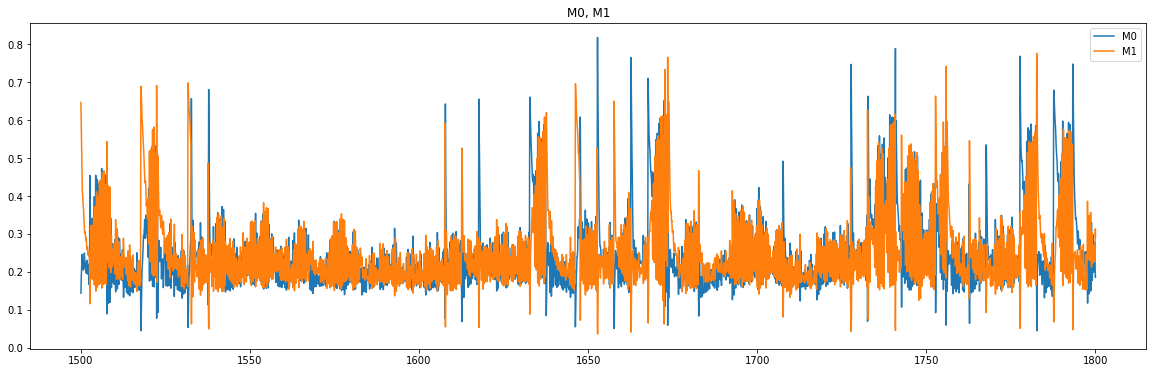

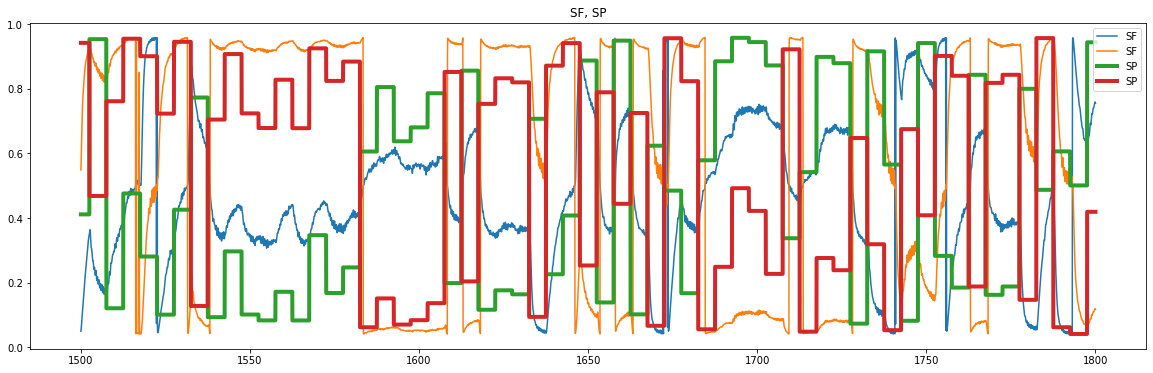

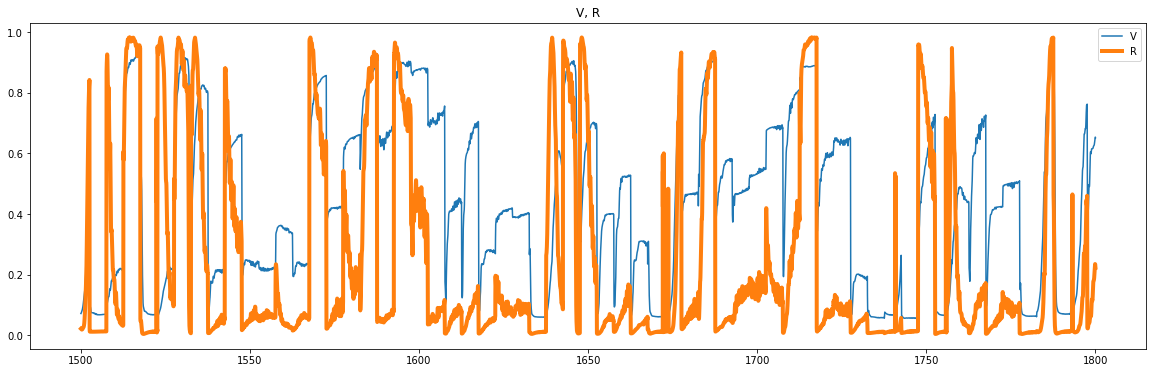

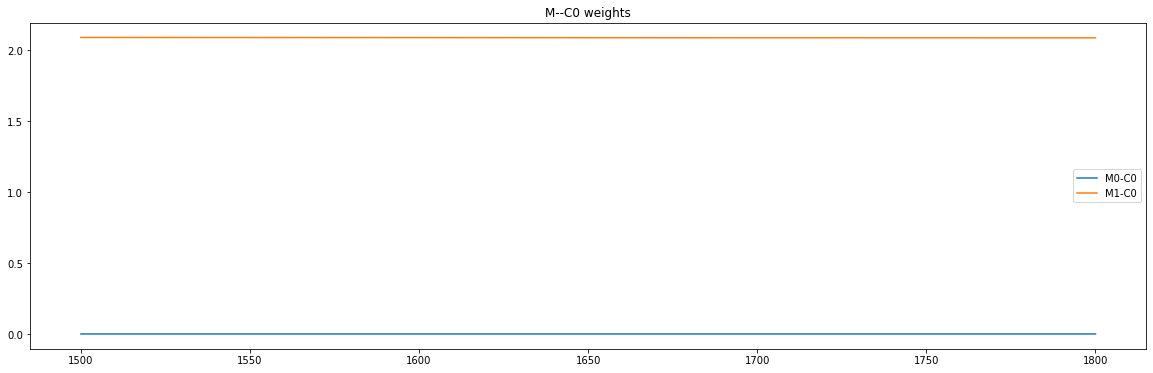

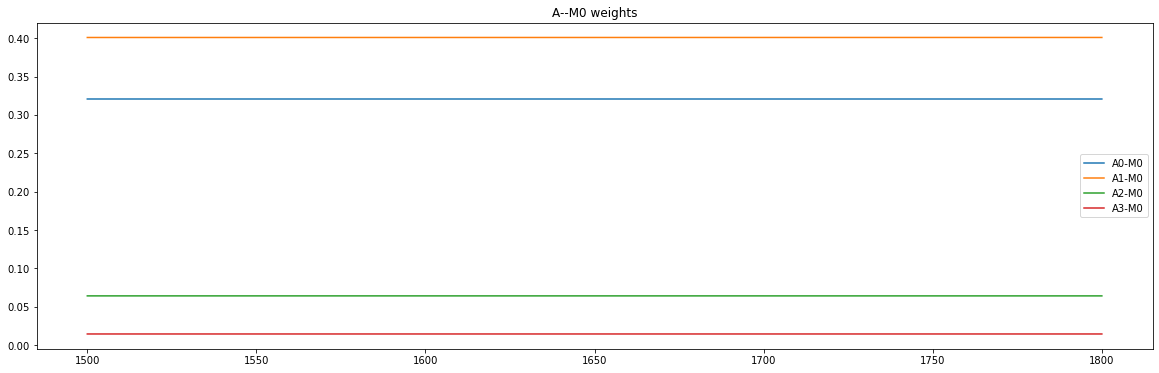

In [55]:
fs = (20,6)

# M
M_fig = plt.figure(figsize=fs)
M_data = np.array(data[M])
plt.plot(times, M_data.transpose())
plt.legend(['M0', 'M1'])
plt.title('M0, M1')
#print(M_data[:,-1])

# SF, SP
SF_fig = plt.figure(figsize=fs)
SF_data = np.array(data[SF])
SP_data = np.array(data[SP])
plt.plot(times, SF_data.transpose(), label='SF')
plt.plot(times, SP_data.transpose(), label='SP', linewidth=4)
plt.legend()
plt.title('SF, SP')
plt.show()
#print('SF = [%f]' % (SF_data[0,-1]))
#print('SP = [%f]' % (SP_data[0,-1]))

# V, R
V_fig = plt.figure(figsize=fs)
V_data = np.array(data[V])
plt.plot(times, V_data.transpose())
plt.title('V, R')
R_data = np.array(data[R])
plt.plot(times, R_data.transpose(), linewidth=4)
plt.legend(['V', 'R'])

# M--C0 weights
W_fig1 = plt.figure(figsize=fs)
w_track_data = np.array(data[M_C0_track])
plt.plot(times, w_track_data.transpose())
plt.legend(['M0-C0', 'M1-C0'])
plt.title('M--C0 weights')

# A--M0 weights
W_fig2 = plt.figure(figsize=fs)
w_track_data2 = np.array(data[A_M0_track])
plt.plot(times, w_track_data2.transpose())
plt.legend(['A0-M0', 'A1-M0', 'A2-M0', 'A3-M0'])
plt.title('A--M0 weights')

plt.show()

Text(0.5, 1.0, 'SPF')

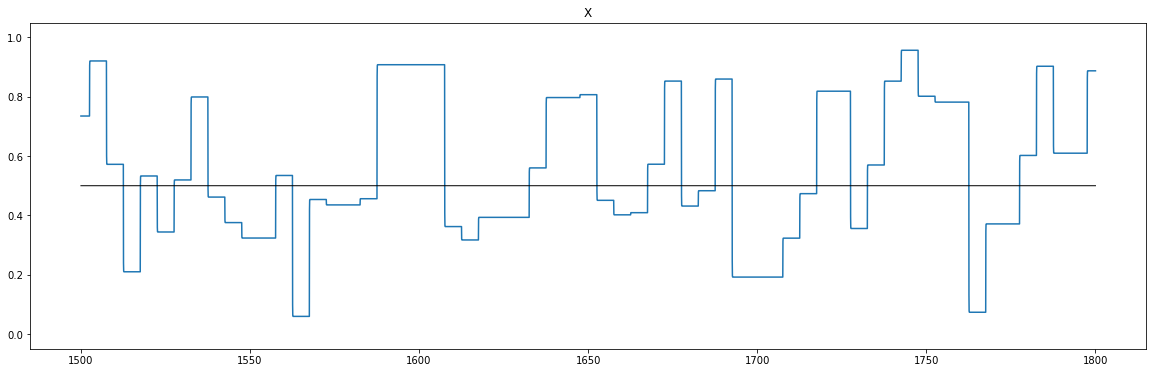

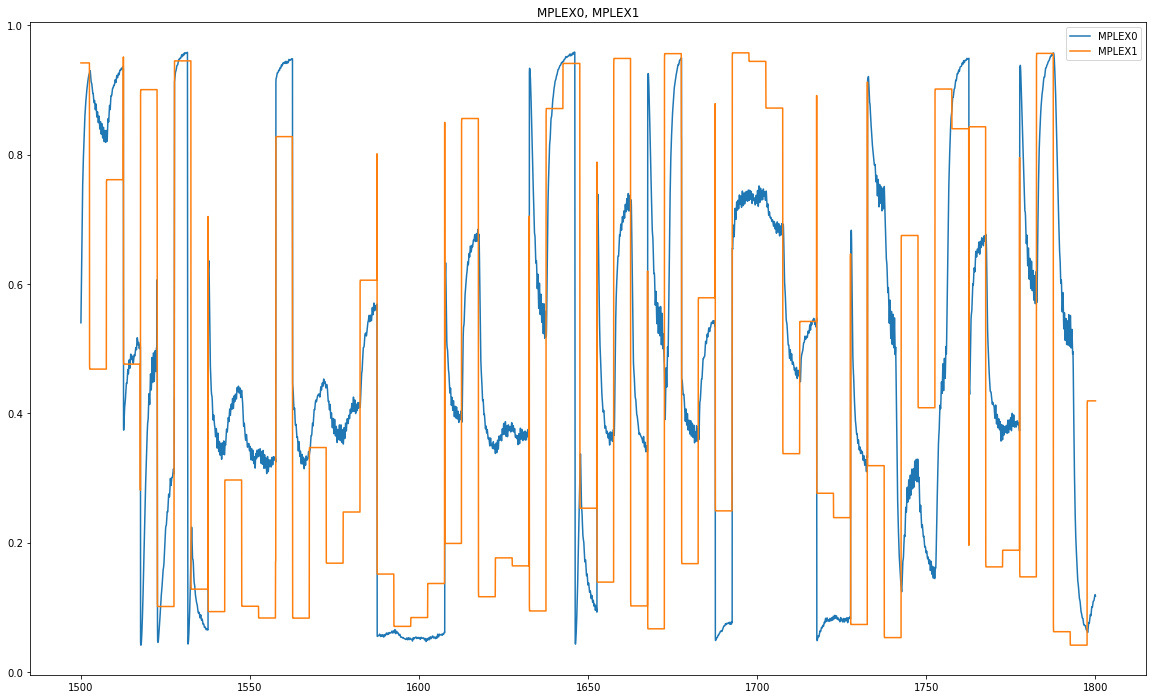

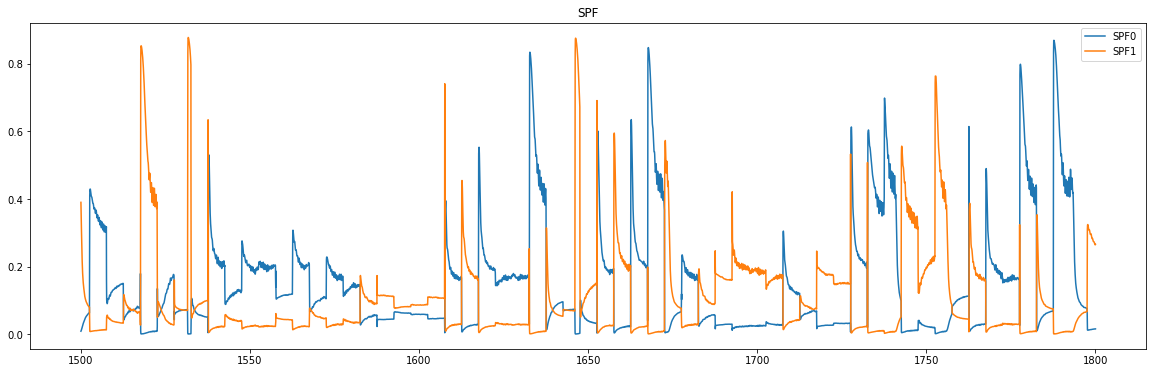

In [56]:
# X
X_fig = plt.figure(figsize=fs)
X_data = np.array(data[X])
plt.plot(times, X_data.transpose())
plt.plot(times, 0.5*np.ones(len(times)), 'k', linewidth=1)
plt.ylim([-0.05,1.05])
#plt.legend(['X'])
plt.title('X')

fs = (20,12)
# MPLEX
MPLEX_fig = plt.figure(figsize=fs)
MPLEX_data = np.array(data[MPLEX])
plt.plot(times, MPLEX_data.transpose())
plt.legend(['MPLEX0', 'MPLEX1'])
plt.title('MPLEX0, MPLEX1')

# SPF
fs = (20,6)
SPF_fig = plt.figure(figsize=fs)
SPF_data = np.array(data[SPF])
plt.plot(times, SPF_data.transpose())
plt.legend(['SPF0', 'SPF1'])
plt.title('SPF')

Text(0.5, 1.0, 'C1')

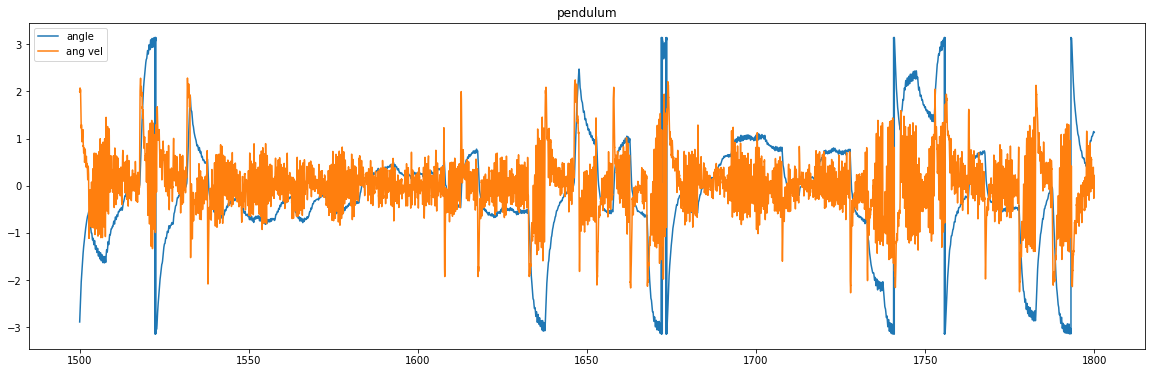

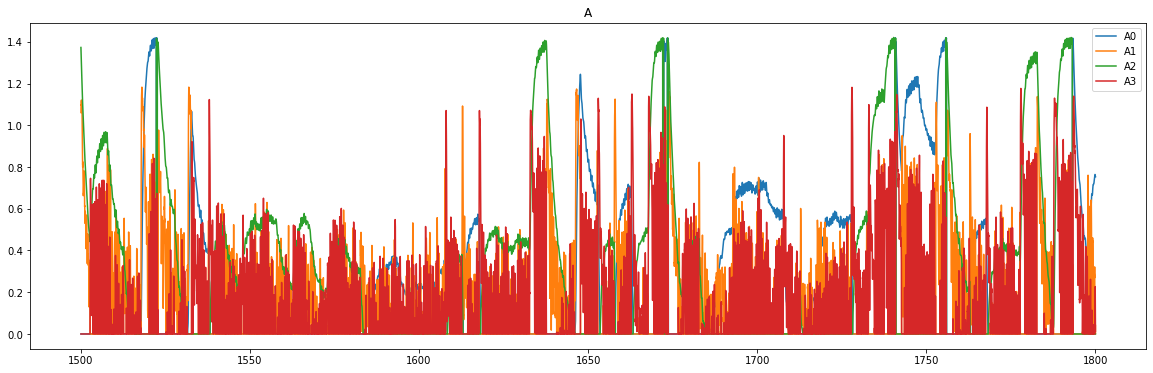

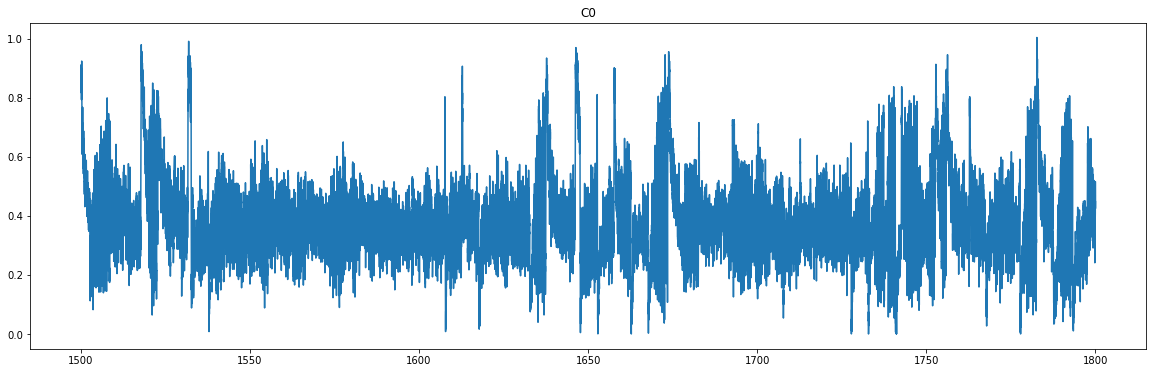

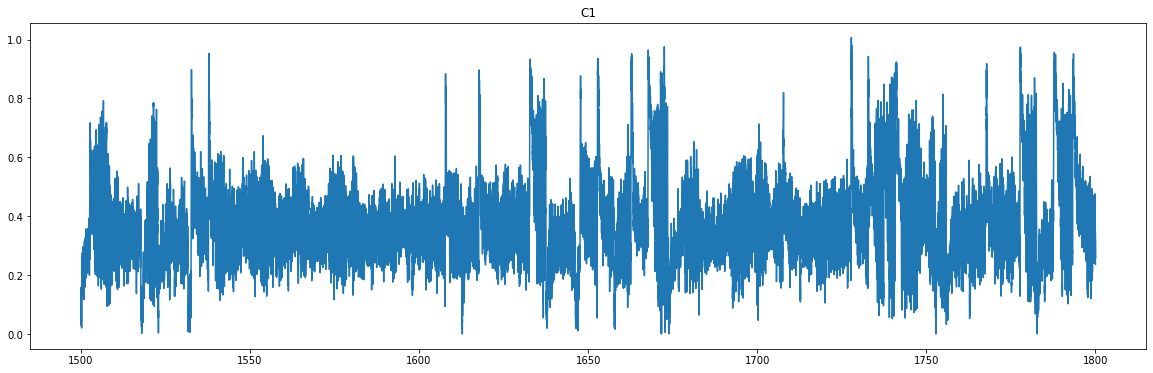

In [57]:
# P
P_fig = plt.figure(figsize=fs)
P_data = plant_data[P]
plt.plot(times, P_data[:,0], label='angle')
plt.plot(times, P_data[:,1], label='ang vel')
plt.legend()
plt.title('pendulum')
#print("angle: %f, vel: %f" % (P_data[-1,0],P_data[-1,1]))

# A
A_fig = plt.figure(figsize=fs)
A_data = np.array(data[A])
plt.plot(times, A_data.transpose())
plt.legend(['A0', 'A1', 'A2', 'A3'])
plt.title('A')
#print(A_data[:,-1])

# L
# L_fig = plt.figure(figsize=fs)
# L_data = np.array(data[L])
# plt.plot(times, L_data.transpose())
# plt.title('L')

# C0
C0_fig = plt.figure(figsize=fs)
C0_data = np.array(data[C[0]])
plt.plot(times, C0_data.transpose())
#plt.plot(times, data[dc_track[0]], linewidth=3)
plt.title('C0')
#print(C0_data[-1])

# C1
C1_fig = plt.figure(figsize=fs)
C1_data = np.array(data[C[1]])
plt.plot(times, C1_data.transpose())
#plt.plot(times, data[dc_track[1]], linewidth=3)
plt.title('C1')
#print(C1_data[-1])


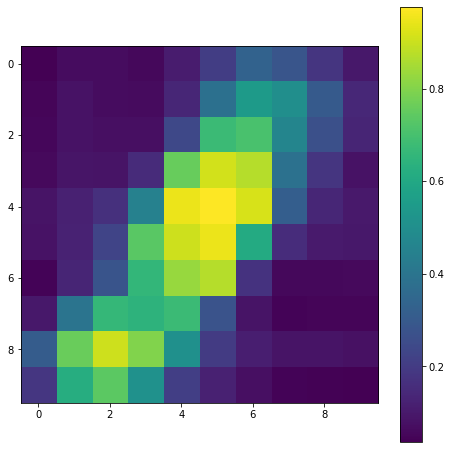

array([[0.03663232, 0.06635603, 0.06689727, 0.0551113 , 0.10881875,
        0.20672121, 0.33377181, 0.28607602, 0.18299205, 0.09698486],
       [0.04873321, 0.08345808, 0.06869369, 0.06241171, 0.1369772 ,
        0.38379932, 0.5503857 , 0.5019612 , 0.3018425 , 0.14162395],
       [0.05224251, 0.08320472, 0.0741161 , 0.07517788, 0.23975075,
        0.6770459 , 0.7086651 , 0.46513523, 0.26507302, 0.13313681],
       [0.05978035, 0.08945488, 0.08802473, 0.15100178, 0.75805755,
        0.91424086, 0.87163717, 0.38678229, 0.18024895, 0.08379441],
       [0.08696136, 0.12443456, 0.16843773, 0.44859412, 0.94752426,
        0.97682265, 0.91826428, 0.31934021, 0.13678407, 0.09983801],
       [0.08118506, 0.12702346, 0.23075355, 0.7360729 , 0.90436851,
        0.94966948, 0.61254327, 0.15774689, 0.10425649, 0.09871109],
       [0.04439705, 0.13326452, 0.27998521, 0.65762118, 0.83176661,
        0.87344191, 0.17506179, 0.05712618, 0.05564099, 0.0607353 ],
       [0.0978421 , 0.39740687, 0.6636214

In [58]:
# L__V connections
L__V_w_mat = np.zeros((No2, No2))
for i in range(No2):
    for j in range(No2):
        w = net.syns[V[0]][i*No2 + j].w
        #print("%.2f" % (w), end=' ')
        L__V_w_mat[i,No2-j-1] = w
    #print("\n")
    
L__V_w_mat_fig = plt.figure(figsize=(8,8))
axs = plt.subplot(1,1,1)
cs = axs.imshow(L__V_w_mat)
L__V_w_mat_fig.colorbar(cs)
plt.show()
L__V_w_mat

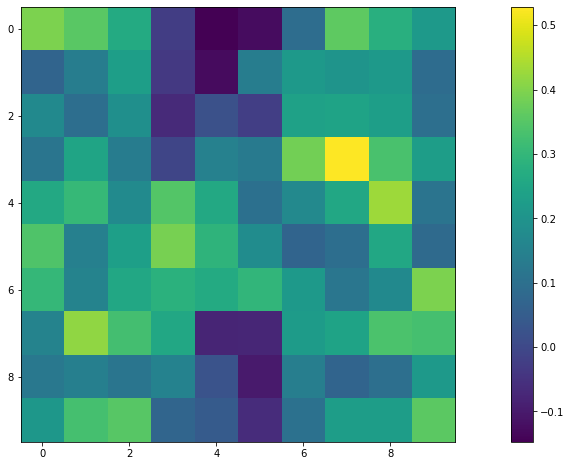

array([[ 0.39474052,  0.35590574,  0.26706843, -0.02500897, -0.14710454,
        -0.12580595,  0.0950062 ,  0.36076114,  0.27792653,  0.21853327],
       [ 0.06962064,  0.13952406,  0.23124106, -0.03436128, -0.12797696,
         0.13977028,  0.2174572 ,  0.20131911,  0.21769026,  0.09166837],
       [ 0.17363557,  0.09605877,  0.19017015, -0.06776807,  0.0196131 ,
        -0.02117057,  0.23847234,  0.24449851,  0.23054672,  0.10044944],
       [ 0.11660097,  0.24823069,  0.13611752, -0.00633325,  0.1487135 ,
         0.13021445,  0.38413718,  0.52831986,  0.33559294,  0.22913322],
       [ 0.26168292,  0.30454261,  0.17606894,  0.34764731,  0.25997355,
         0.1017967 ,  0.17055487,  0.25813881,  0.42880369,  0.11223702],
       [ 0.34247782,  0.14613928,  0.23414366,  0.38931201,  0.29273576,
         0.18058725,  0.0709871 ,  0.09679339,  0.25698757,  0.08641296],
       [ 0.30213221,  0.15492827,  0.25799709,  0.28491307,  0.26573216,
         0.29808008,  0.21770648,  0.11723977

In [59]:
# L__X connections
matty0 = np.zeros((No2, No2))
matty1 = np.zeros((No2, No2))
for i in range(No2):
    for j in range(No2):
        w0 = net.syns[X[0]][i*No2 + j].w
        #w1 = net.syns[X[1]][i*No2 + j+4].w
        #print("%.2f" % (w), end=' ')
        matty0[i,No2-j-1] = w0
        #matty1[i,No2-j-1] = w1
    #print("\n")
    
matty_fig = plt.figure(figsize=(20,8))
axs0 = plt.subplot(1,1,1)
cs0 = axs0.imshow(matty0)
plt.colorbar(cs0)
# axs1 = plt.subplot(1,2,2)
# cs1 = axs1.imshow(matty1)
# plt.colorbar(cs1)
plt.show()
matty0

In [ ]:
array([[ 0.40435708,  0.36871299,  0.26451075, -0.03837009, -0.13858531,
        -0.11918675,  0.08805108,  0.35954017,  0.28160991,  0.22341333],
       [ 0.06779194,  0.14292059,  0.23143288, -0.0618048 , -0.11957693,
         0.15248895,  0.19556398,  0.17705438,  0.20277426,  0.08636195],
       [ 0.18065358,  0.11469676,  0.21679759, -0.06333571,  0.06221226,
        -0.00605851,  0.22693306,  0.21526107,  0.20965308,  0.09286304],
       [ 0.12456804,  0.27708455,  0.16502472,  0.02446249,  0.20895169,
         0.15346635,  0.3624493 ,  0.488407  ,  0.31383964,  0.22821201],
       [ 0.26580795,  0.30417213,  0.16856411,  0.35826577,  0.29918493,
         0.10389838,  0.12804004,  0.20650249,  0.40000456,  0.10208297],
       [ 0.34789069,  0.13280186,  0.21090382,  0.36931839,  0.31858035,
         0.18969625,  0.06360156,  0.07702185,  0.25329374,  0.08538817],
       [ 0.30934394,  0.14356544,  0.23947449,  0.2736469 ,  0.29808178,
         0.32226312,  0.23949713,  0.132105  ,  0.18147756,  0.40692339],
       [ 0.15020732,  0.39810448,  0.30859546,  0.25977658, -0.01429574,
        -0.03358934,  0.23723708,  0.2587094 ,  0.3461205 ,  0.33594188],
       [ 0.11923504,  0.12781651,  0.08368297,  0.1752099 ,  0.11074496,
        -0.03361047,  0.16139752,  0.07959077,  0.10042465,  0.22221379],
       [ 0.22105   ,  0.32479307,  0.34772711,  0.07809769,  0.1110224 ,
        -0.01490563,  0.11572101,  0.24252722,  0.23528877,  0.36626529]])

In [23]:
# Storing the M__C and A__M connections
M__C_mat = np.zeros((2,2)) # rows are target (C) neurons
for m_idx, m_id in enumerate(M):
    for c_idx, c_id in enumerate(C):
        syn_list = net.syns[c_id]
        for syn in syn_list:
            if syn.preID == m_id:
                M__C_mat[c_idx, m_idx] = syn.w
                break
                
A__M_mat = np.zeros((2,4)) # rows are target (M) neurons
for a_idx, a_id in enumerate(A):
    for m_idx, m_id in enumerate(M):
        syn_list = net.syns[m_id]
        for syn in syn_list:
            if syn.preID == a_id:
                A__M_mat[m_idx, a_idx] = syn.w
                break
print(M__C_mat)
print(A__M_mat)

[[0.         2.11418172]
 [2.11423622 0.        ]]
[[0.32066114 0.40081713 0.06409838 0.01442335]
 [0.04208048 0.         0.33684502 0.4210745 ]]


In [7]:
plotty = plotter(net, times, data)

In [12]:
plotty.act_anim(S1+S2+L+R+V, 0.5, interv=10, slider=False)

In [8]:
plotty.conn_anim(L, V)

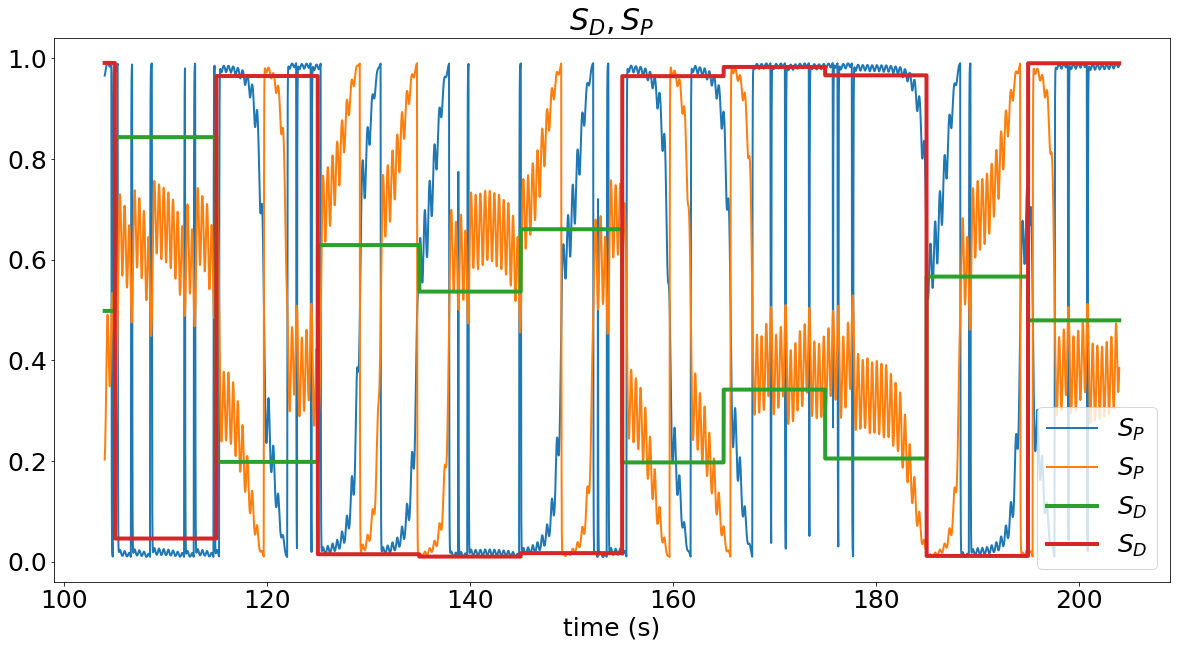

In [18]:
# A figure with more formatting
SPF_fig = plt.figure(figsize=(20,10))
SF_data = np.array(data[SF])
SP_data = np.array(data[SP])
plt.plot(times, SF_data.transpose(), label='$S_P$', linewidth=2)
plt.plot(times, SP_data.transpose(), label='$S_D$', linewidth=4)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.legend(fontsize=25)
plt.xlabel('time (s)', fontsize =25)
plt.title('$S_D, S_P$', fontsize=30)
plt.show()

In [4]:
# good initial weights

# M__C
# M[0] has the F-D error, so you want C[0] (which exerts positive torque)
# to be driven by M[1] instead, and C[1] to be driven by M[0]
shift = 0
while not net.syns[C[0]][shift].type is synapse_types.rga:
    shift += 1
net.syns[C[0]][shift].w = 0.1
net.syns[C[0]][shift+1].w = 0.8 # C[0] driven by M[1]
net.syns[C[1]][shift].w = 0.8
net.syns[C[1]][shift+1].w = 0.1

# L__X, L__V
scale = 1. # maximum weight value
def dist(c1, c2):
    """ Periodic distance between 2-dim coordinates c1 and c2. 

        Assumes c1 and c2 are inside the box with corners [-0.5, -0.5], [0.5, 0.5].
    """
    x_dist = min(max(c1[0], c2[0]) - min(c1[0], c2[0]),  # "inner" distance
                 0.5-max(c1[0], c2[0]) + (min(c1[0], c2[0])+0.5) ) # "outer" distance
    y_dist = min(max(c1[1], c2[1]) - min(c1[1], c2[1]),  # "inner" distance
                 0.5-max(c1[1], c2[1]) + (min(c1[1], c2[1])+0.5) ) # "outer" distance
    return np.sqrt(x_dist*x_dist + y_dist*y_dist)

#L__V_iw = np.zeros((No2, No2))
j = 0
for i in range(len(L)):  # Setting L__V weights
    u = net.units[L[i]]
    c = u.coordinates
    d = dist(c, [c[1], c[1]])
    Vsyn = net.syns[V[0]][i]
    Xsyn = net.syns[X[0]][i+j]
    while Xsyn.type != synapse_types.diff_rm_hebbian:
        j +=1
        Xsyn = net.syns[X[0]][i+j]
    if Vsyn.preID == u.ID and Xsyn.preID == u.ID:
        a, b = divmod(i, No2)
        Vsyn.w = scale*(.5 - d)
        Xsyn.w = 0.01 if abs(c[1]-c[0]) < 0.5-max(c[1],c[0]) + min(c[1],c[0])+0.5 else .8
    else:
        print("FAILED!!!!!!!")

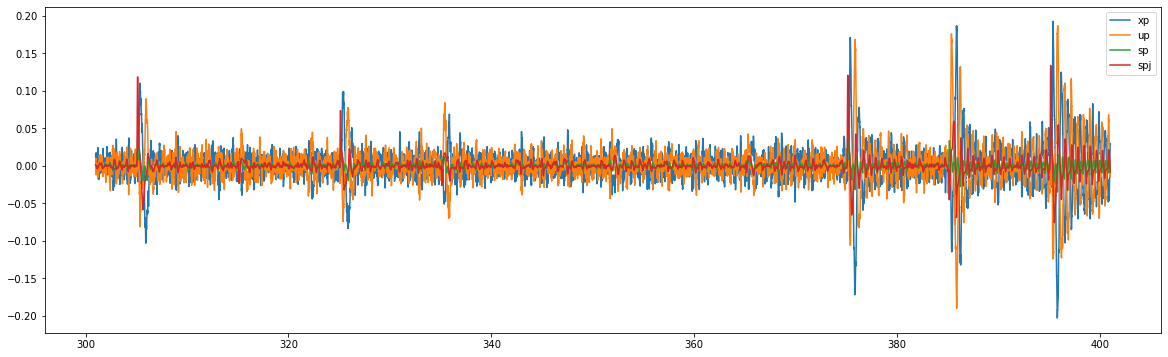

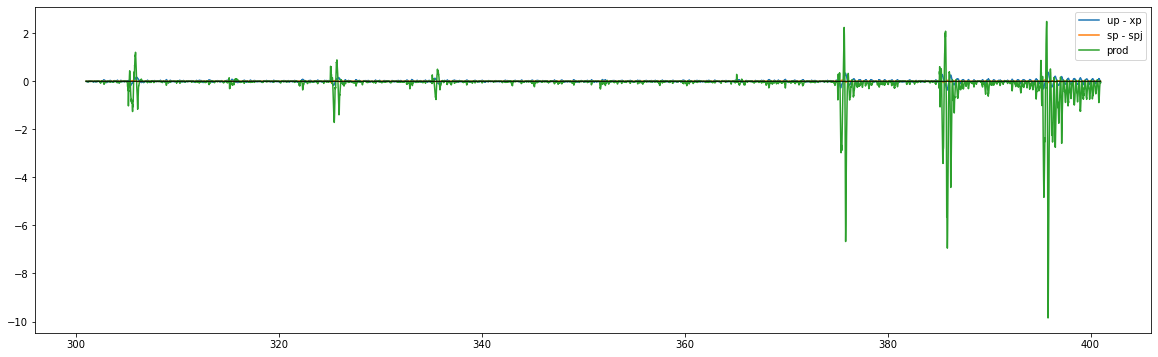

In [20]:
# plot all factors in the M--C0 synaptic plasticity
fs = (20,6)
plastic_fig = plt.figure(figsize=fs)
xp_data = np.array(data[xp_track[0]])
up_data = np.array(data[up_track[0]])
sp_data = np.array(data[sp_track[0]])
spj_data = np.array(data[spj_track[0]])
plt.plot(times, xp_data)
plt.plot(times, up_data)
plt.plot(times, sp_data)
plt.plot(times, spj_data)
plt.legend(['xp', 'up', 'sp', 'spj'])

plastic_fig2 = plt.figure(figsize=fs)
f1 = up_data - xp_data
f2 = sp_data - spj_data
rule = 500. * f1 * f2
plt.plot(times, f1)
plt.plot(times, f2)
plt.plot(times, rule)
plt.plot(times, np.zeros(len(times)), 'k', linewidth=1)
plt.legend(['up - xp', 'sp - spj', 'prod'])
plt.show()

In [11]:
# checking some connections
print("Connections to M0 unit")
for idx, syn in enumerate(net.syns[M[0]]):
    pre_id = syn.preID
    pre_type = net.units[pre_id].type
    if pre_id == P and hasattr(syn, 'plant_out'):
        pre_pop = 'P'
    elif pre_id in A:
        pre_pop = 'A'
    #elif pre_id in L:
    #    pre_pop = 'L'
    elif pre_id in M:
        pre_pop = 'M'
    #elif pre_id in V:
    #    pre_pop = 'V'
    elif pre_id in SPF:
        pre_pop = 'SPF'
    else:
        pre_pop = 'erroneous'
    if pre_pop == 'P':
        plant_out = str(syn.plant_out)
    else:
        plant_out = 'None'
    print('%d) %s (%d) --> M0, w=%f, port=%d, plant_out=%s'%(idx, pre_pop, pre_id, syn.w, syn.port, plant_out))

print("Connections to M1 unit")
for idx, syn in enumerate(net.syns[M[1]]):
    pre_id = syn.preID
    pre_type = net.units[pre_id].type
    if pre_id == P and hasattr(syn, 'plant_out'):
        pre_pop = 'P'
    elif pre_id in A:
        pre_pop = 'A'
    #elif pre_id in L:
    #    pre_pop = 'L'
    elif pre_id in M:
        pre_pop = 'M'
    #elif pre_id in V:
    #    pre_pop = 'V'
    elif pre_id in SPF:
        pre_pop = 'SPF'
    else:
        pre_pop = 'erroneous'
    if pre_pop == 'P':
        plant_out = str(syn.plant_out)
    else:
        plant_out = 'None'
    print('%d) %s (%d) --> M1, w=%f, port=%d, plant_out=%s'%(idx, pre_pop, pre_id, syn.w, syn.port, plant_out))
    
print("Connections to C0 unit")
for idx, syn in enumerate(net.syns[C[0]]):
    pre_id = syn.preID
    pre_type = net.units[pre_id].type
    if pre_id == P and hasattr(syn, 'plant_out'):
        pre_pop = 'P'
    elif pre_id in A:
        pre_pop = 'A'
    elif pre_id in M:
        pre_pop = 'M'
    elif pre_id in C:
        pre_pop = 'C'
    else:
        pre_pop = 'erroneous'
    if pre_pop == 'P':
        plant_out = str(syn.plant_out)
    else:
        plant_out = 'None'
    print('%d) %s (%d) --> C0, w=%f, port=%d, plant_out=%s'%(idx, pre_pop, pre_id, syn.w, syn.port, plant_out))  

print("Connections to C1 unit")
for idx, syn in enumerate(net.syns[C[1]]):
    pre_id = syn.preID
    pre_type = net.units[pre_id].type
    if pre_id == P and hasattr(syn, 'plant_out'):
        pre_pop = 'P'
    elif pre_id in A:
        pre_pop = 'A'
    elif pre_id in M:
        pre_pop = 'M'
    elif pre_id in C:
        pre_pop = 'C'
    else:
        pre_pop = 'erroneous'
    if pre_pop == 'P':
        plant_out = str(syn.plant_out)
    else:
        plant_out = 'None'
    print('%d) %s (%d) --> C1, w=%f, port=%d, plant_out=%s'%(idx, pre_pop, pre_id, syn.w, syn.port, plant_out))  

    
print("Connections to afferent units")
for idx, syn in enumerate(net.syns[A[2]]):
    pre_id = syn.preID
    pre_type = net.units[pre_id].type
    if pre_id == P and hasattr(syn, 'plant_out'):
        pre_pop = 'P'
    elif pre_id in A:
        pre_pop = 'A'
    else:
        pre_pop = 'erroneous'
    if pre_pop == 'P':
        plant_out = str(syn.plant_out)
    else:
        plant_out = 'None'
    print('%d) %s (%d) --> A, w=%f, port=%d, plant_out=%s'%(idx, pre_pop, pre_id, syn.w, syn.port, plant_out))

print("Connections to plant")
for idx, syn in enumerate(net.plants[P].inp_syns[0]):
    pre_id = syn.preID
    pre_type = net.units[pre_id].type
    if pre_id in C:
        pre_pop = 'C'
    else:
        pre_pop = 'erroneous'
    print('%d) %s (%d, %s) --> P, w=%f'%(idx, pre_pop, pre_id, pre_type, syn.w))
    
print("Connections to MPLEX units")
for idx, syn in enumerate(net.syns[MPLEX[0]]):
    pre_id = syn.preID
    pre_type = net.units[pre_id].type
    if pre_id in X:
        pre_pop = 'X'
    elif pre_id in SF:
        pre_pop = 'SF'
    elif pre_id in SP:
        pre_pop = 'SP'
    else:
        pre_pop = 'erroneous'
    print('%d) %s (%d) --> MPLEX, w=%f, port=%d'%(idx, pre_pop, pre_id, syn.w, syn.port))  

print("Connections to SF units")
for idx, syn in enumerate(net.syns[SF[1]]):
    pre_id = syn.preID
    pre_type = net.units[pre_id].type
    if pre_id == P and hasattr(syn, 'plant_out'):
        pre_pop = 'P'
    elif pre_id in T:
        pre_pop = 'T'
    else:
        pre_pop = 'erroneous'
    print('%d) %s (%d) --> SF, w=%f, port=%d, plant_out=%s'%
          (idx, pre_pop, pre_id, syn.w, syn.port, plant_out))

print("Connections to X unit")
for idx, syn in enumerate(net.syns[X[0]]):
    pre_id = syn.preID
    pre_type = net.units[pre_id].type
    if pre_id in L:
        pre_pop = 'L'
    elif pre_id in V:
        pre_pop = 'V'
    else:
        pre_pop = 'erroneous'
    print('%d) %s (%d) --> X, w=%f, port=%d'%(idx, pre_pop, pre_id, syn.w, syn.port))  
    
print("Connections to V unit")
for idx, syn in enumerate(net.syns[V[0]]):
    pre_id = syn.preID
    pre_type = net.units[pre_id].type
    if pre_id in L:
        pre_pop = 'L'
    elif pre_id in R:
        pre_pop = 'R'
    else:
        pre_pop = 'erroneous'
    print('%d) %s (%d) --> V, w=%f, port=%d'%(idx, pre_pop, pre_id, syn.w, syn.port))  


Connections to M0 unit
0) A (0) --> M0, w=0.219605, port=2, plant_out=None
1) A (1) --> M0, w=0.248533, port=2, plant_out=None
2) A (2) --> M0, w=0.224219, port=2, plant_out=None
3) A (3) --> M0, w=0.207640, port=2, plant_out=None
4) M (107) --> M0, w=-1.000000, port=3, plant_out=None
5) SPF (155) --> M0, w=1.000000, port=1, plant_out=None
Connections to M1 unit
0) A (0) --> M1, w=0.252435, port=2, plant_out=None
1) A (1) --> M1, w=0.167266, port=2, plant_out=None
2) A (2) --> M1, w=0.215700, port=2, plant_out=None
3) A (3) --> M1, w=0.264603, port=2, plant_out=None
4) M (106) --> M1, w=-1.000000, port=3, plant_out=None
5) SPF (156) --> M1, w=1.000000, port=1, plant_out=None
Connections to C0 unit
0) C (5) --> C0, w=-1.500000, port=1, plant_out=None
1) M (106) --> C0, w=0.014658, port=0, plant_out=None
2) M (107) --> C0, w=2.066072, port=0, plant_out=None
Connections to C1 unit
0) C (4) --> C1, w=-1.500000, port=1, plant_out=None
1) M (106) --> C1, w=2.066016, port=0, plant_out=None
2)

---